# Assignment 3: Data Analytics
188.429 Business Intelligence WS2021
Gunnar Sjúrðarson Knudsen & Katrin Schreiberhuber

## Remaining todo:
A lot; among other:
* Write the report (https://www.overleaf.com/read/hrkpxtprgkrf)
  * Answer questions in the report, that isn't answered in this notebook
* Evaluate with validation
* Retrain using full train and validation data
* Compare to state-of-the-art performance from the literature
* add a baseline?
* Hyperparameter search
* Compare to success criteria not yet defined

## Sources:
VERY heavily "inspired" from:
* https://www.kaggle.com/edisonbejarano/productivity-prediction-of-garment-employees
* https://www.kaggle.com/yohanesnuwara/garment-industry-productivity-analytics
* https://www.kaggle.com/rajatsaklani18/garment-workers-productivity-prediction
* https://www.kaggle.com/sasakitetsuya/mae-0-080-with-xgboost
* https://www.kaggle.com/eminecerit/notebook-garment-classification
* https://www.kaggle.com/shripadrao/visualization-of-productivity-of-garment-workers



## Context
stuff stuff

## Content
stuff stuff stuff

## Task details

## Expected results

## outline of file?

## Summary?


Stuff stuff stuff **Productivity Prediction of Garment Employees Data Set** stuff stuff stuff

https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees#

## Setup

### Required libraries

In [1]:
# Standard Data Science toolkit
import numpy as np
import pandas as pd
import warnings
from datetime import datetime

# Visualization toolkits
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Machine Learning / Modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor


import random
random.seed(420)
np.random.seed(69)

### Visualization settings

In [2]:
sns.set_style(style='white')
sns.set(rc={
    'figure.figsize': (12,7),
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},
    font_scale=1.5)
custom_colors=["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)
background_color='#fbfbfb'

### Constants

In [3]:
DATA_LOCATION = 'raw_data/garments_worker_productivity.csv'
GRAPHICS_LOCATION = 'output_graphics/'

### Read in data

In [4]:
df = pd.read_csv(DATA_LOCATION, parse_dates=['date'])#, index_col=['date'])
df.set_index('date', drop = False, inplace=True)
df

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
date,,,,,,,,,,,,,,,
2015-01-01,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
2015-01-01,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2015-01-01,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
2015-01-01,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
2015-01-01,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-11,2015-03-11,Quarter2,finishing,Wednesday,10,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
2015-03-11,2015-03-11,Quarter2,finishing,Wednesday,8,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
2015-03-11,2015-03-11,Quarter2,finishing,Wednesday,7,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625


## Exploratory Data Analysis
Get a feel for what the data contains, so that we know which preprocessing is needed

### Column Description
_Taken directly from the source_
  * 01 `date` : Date in MM-DD-YYYY
  * 02 `day` : Day of the Week
  * 03 `quarter` : A portion of the month. A month was divided into four quarters
  * 04 `department` : Associated department with the instance
  * 05 `team_no` : Associated team number with the instance
  * 06 `no_of_workers` : Number of workers in each team
  * 07 `no_of_style_change` : Number of changes in the style of a particular product
  * 08 `targeted_productivity` : Targeted productivity set by the Authority for each team for each day.
  * 09 `smv` : Standard Minute Value, it is the allocated time for a task
  * 10 `wip` : Work in progress. Includes the number of unfinished items for products
  * 11 `over_time` : Represents the amount of overtime by each team in minutes
  * 12 `incentive` : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
  * 13 `idle_time` : The amount of time when the production was interrupted due to several reasons
  * 14 `idle_men` : The number of workers who were idle due to production interruption
  * 15 `actual_productivity` : The actual % of productivity that was delivered by the workers. It ranges from 0-1. 

### First glance
First step is to just apply standard pandas functions to see what we are working with:

In [5]:
print(f'Shape: {df.shape}')
print("------------------------------------------------")
display(df.describe())
print("------------------------------------------------")
print("datatypes:")
print(df.dtypes)
print("------------------------------------------------")
print("Skew:")
print(df.skew())
print("------------------------------------------------")
display(df.info())

Shape: (1197, 15)
------------------------------------------------


,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


------------------------------------------------
datatypes:
date                     datetime64[ns]
quarter                          object
department                       object
day                              object
team                              int64
targeted_productivity           float64
smv                             float64
wip                             float64
over_time                         int64
incentive                         int64
idle_time                       float64
idle_men                          int64
no_of_style_change                int64
no_of_workers                   float64
actual_productivity             float64
dtype: object
------------------------------------------------
Skew:
team                      0.009848
targeted_productivity    -2.144150
smv                       0.405937
wip                       9.741786
over_time                 0.673287
incentive                15.790746
idle_time                20.545425
idle_men                  

None

**Intermediary Conclusion:** Blaaaerb.... Nothing too exciting to see here

### Categorial vs Numeric Attributes
Splitting these up, for separate exploration

In [6]:
category = df.select_dtypes(include='object')
categorial_columns = category.columns
numerical = df.select_dtypes(exclude='object')
numerical_columns = numerical.columns

print("Categorical Attributes:")
for col in category.columns:
    print(f"{col}")
    print(category[col].unique())
    print()

print("Numerical Attributes:")
for n in numerical.columns:
    print(n)

Categorical Attributes:
quarter
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']

department
['sweing' 'finishing ' 'finishing']

day
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']

Numerical Attributes:
date
team
targeted_productivity
smv
wip
over_time
incentive
idle_time
idle_men
no_of_style_change
no_of_workers
actual_productivity


#### Categorical Distribution

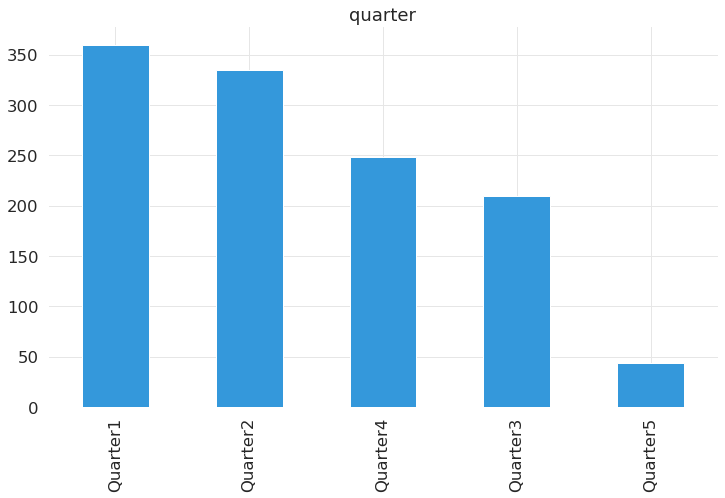

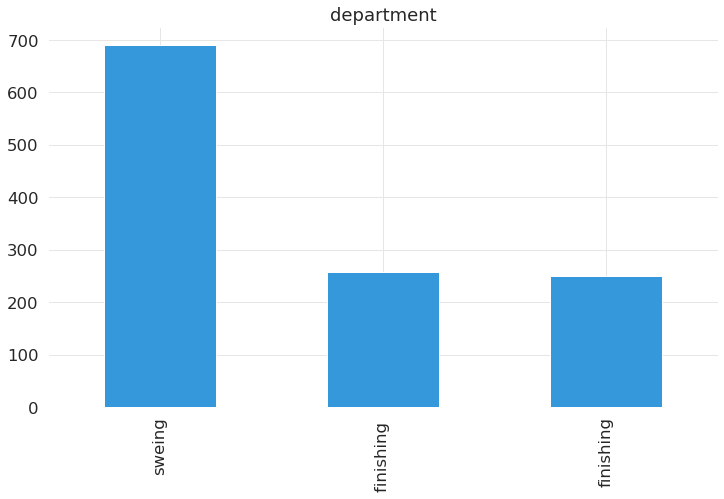

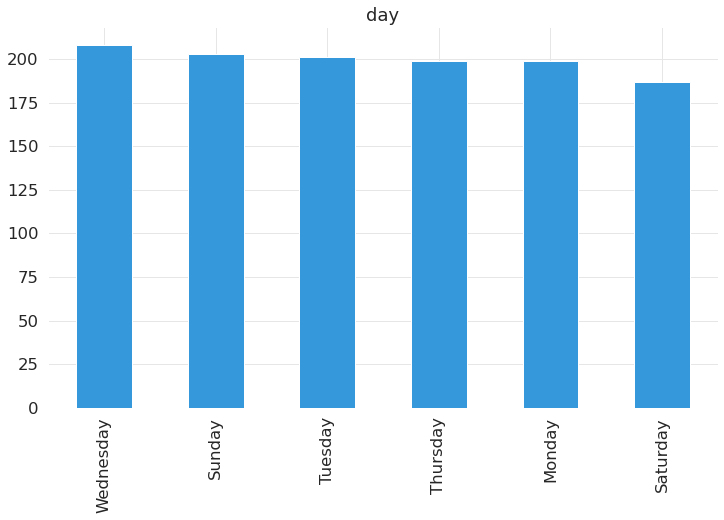

In [7]:
for i in range(len(categorial_columns)):
    df[categorial_columns[i]].value_counts().plot(kind='bar', title=categorial_columns[i])
    plt.savefig(GRAPHICS_LOCATION + 'EDA_Categorical_Distribution_' + categorial_columns[i] + '.png')
    plt.show()

**Intermediary Conclusion:** Bllaaaaerb

#### Numerical Distribution

Skipping


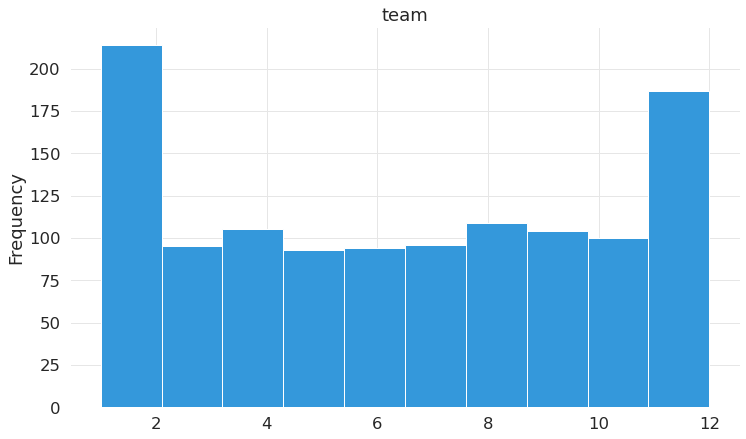

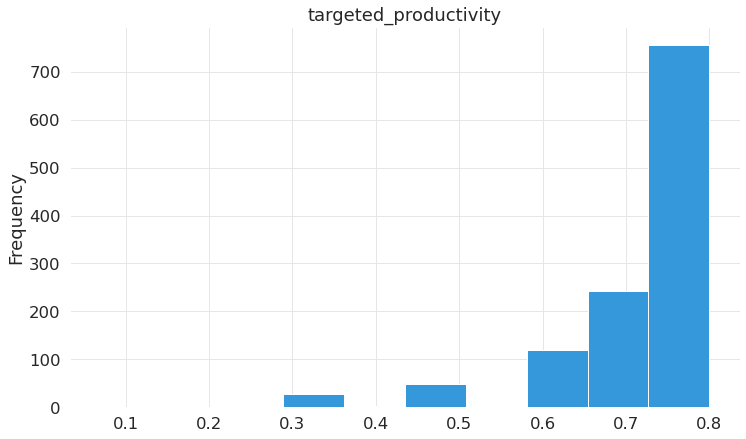

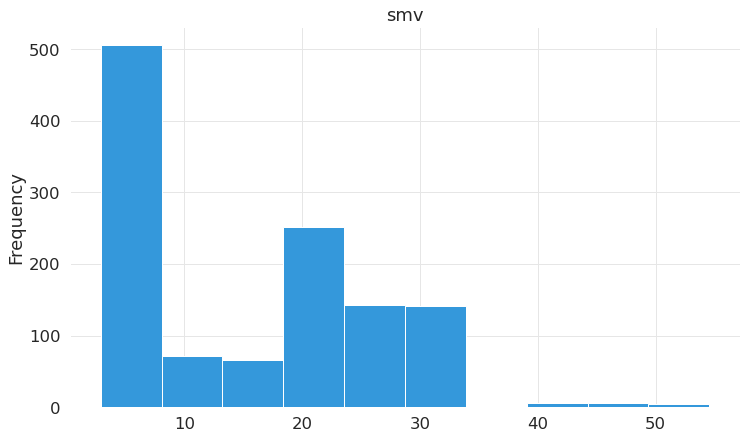

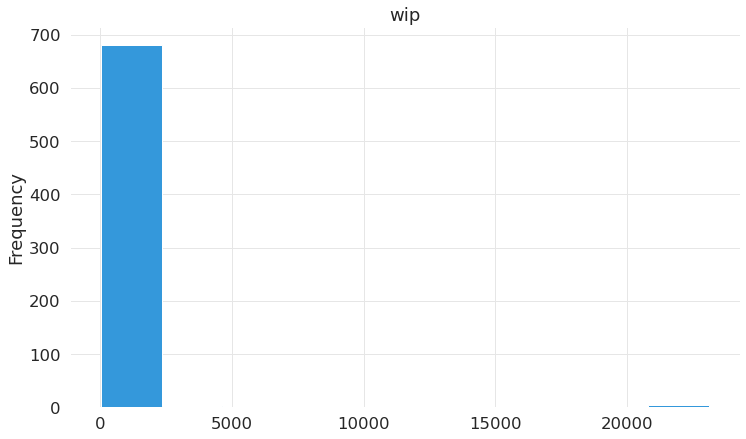

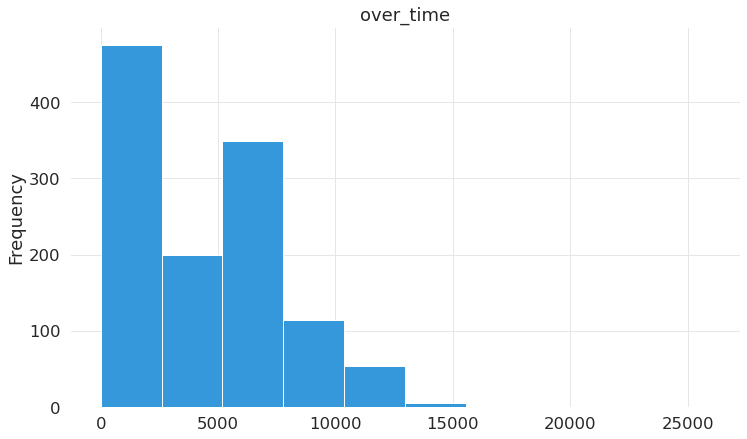

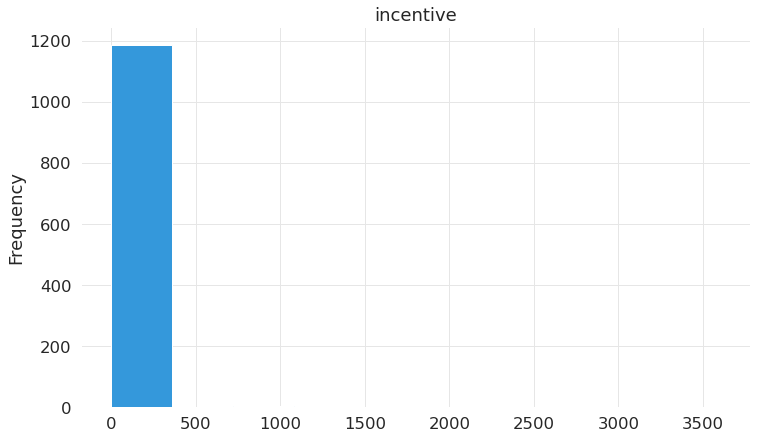

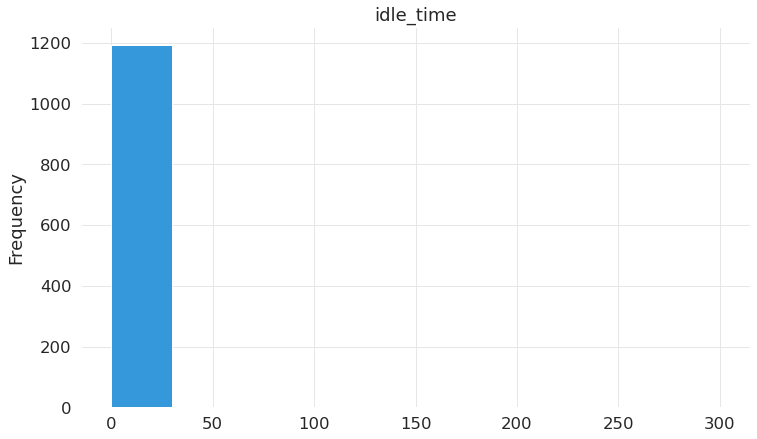

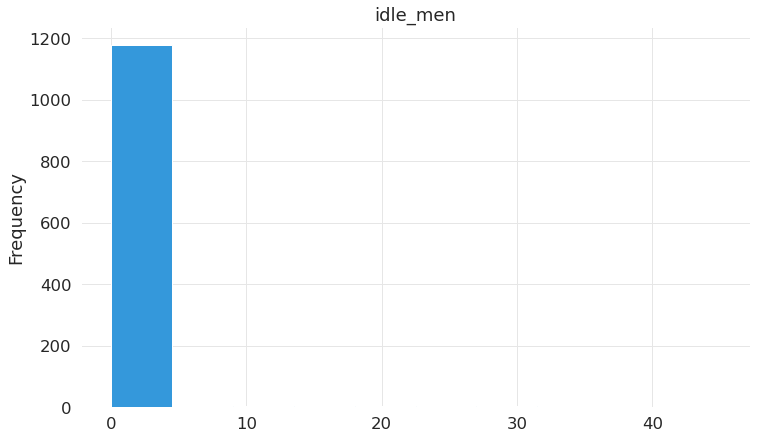

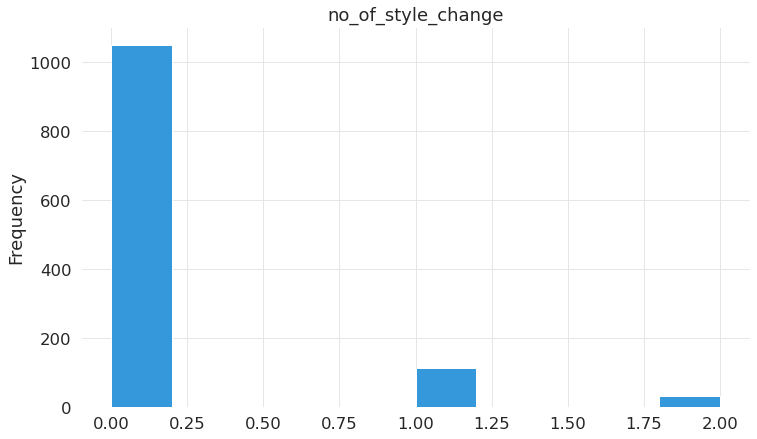

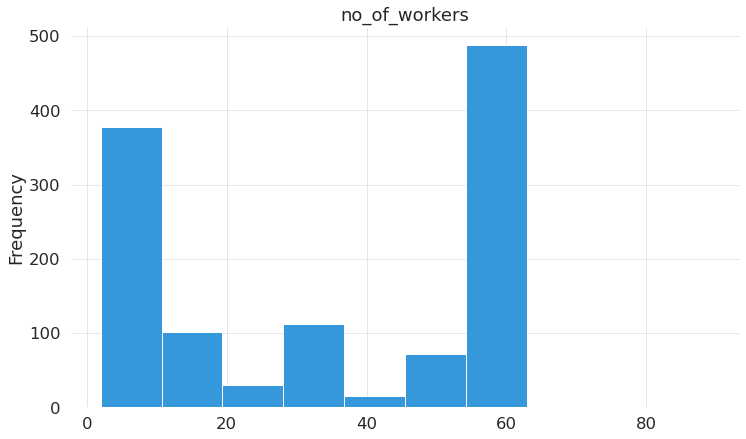

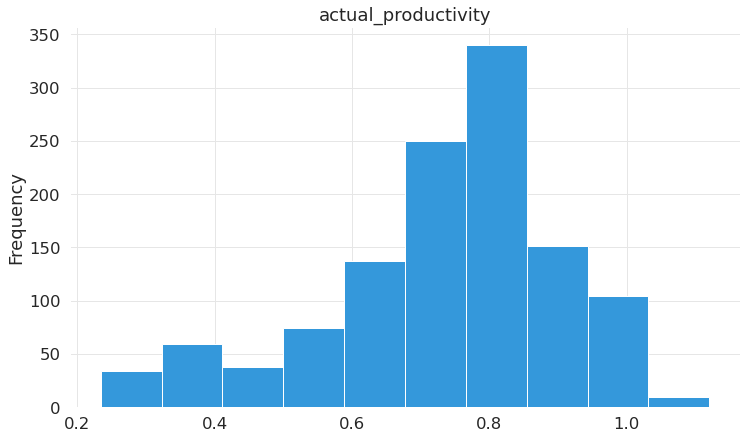

In [8]:
for i in range(len(numerical.columns)):
    if numerical.columns[i] == 'date':
        print('Skipping')
    else:
        numerical.iloc[:, i].plot(kind='hist', title=numerical.columns[i])
        plt.savefig(GRAPHICS_LOCATION + 'EDA_Numerical_Distribution_' + numerical.columns[i] + '.png')
        plt.show()

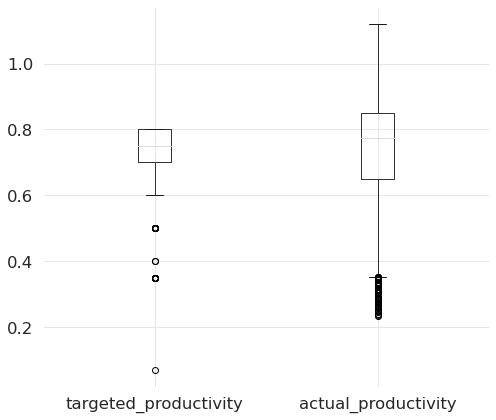

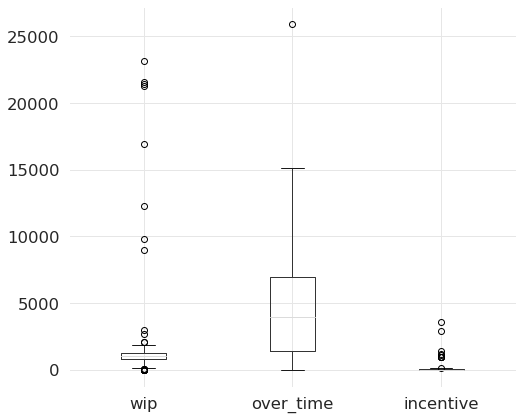

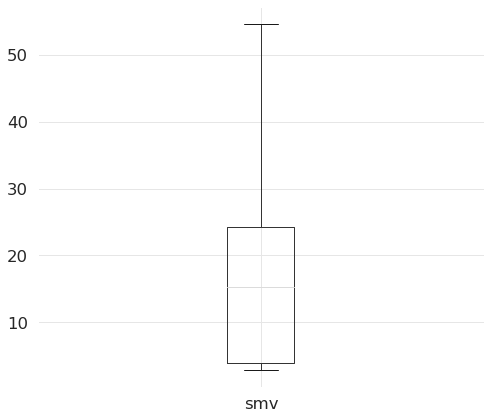

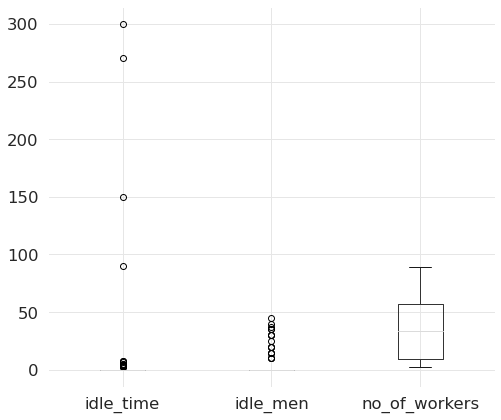

In [9]:
numerical.boxplot(column = [ 'targeted_productivity', 'actual_productivity'],figsize=(8,7))
plt.savefig(GRAPHICS_LOCATION + 'EDA_Numerical_boxplot_1.png')
plt.show()

numerical.boxplot(column=['wip', 'over_time', 'incentive'],figsize=(8,7))
plt.savefig(GRAPHICS_LOCATION + 'EDA_Numerical_boxplot_2.png')
plt.show()

numerical.boxplot(column = ['smv'],figsize=(8,7))
plt.savefig(GRAPHICS_LOCATION + 'EDA_Numerical_boxplot_3.png')
plt.show()

numerical.boxplot(column = [ 'idle_time', 'idle_men',  'no_of_workers'] ,figsize=(8,7))
plt.savefig(GRAPHICS_LOCATION + 'EDA_Numerical_boxplot_4.png')
plt.show()

**Intermediary Conclusion:** Bllaaaaerb

#### Categorical In disguise
We see that there are (at least) two numeric attributes that should/could be treated as categorical

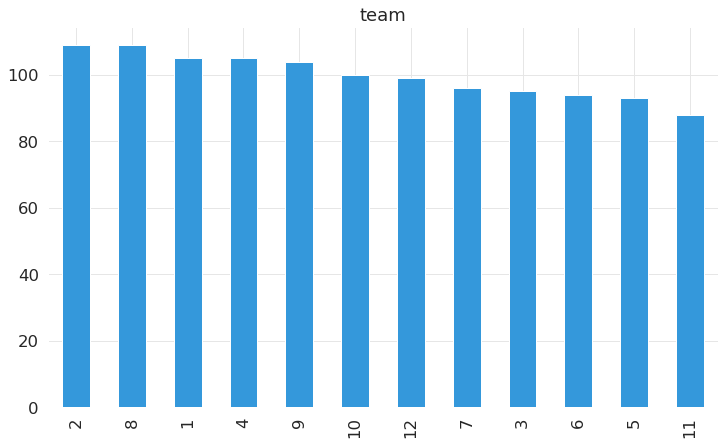

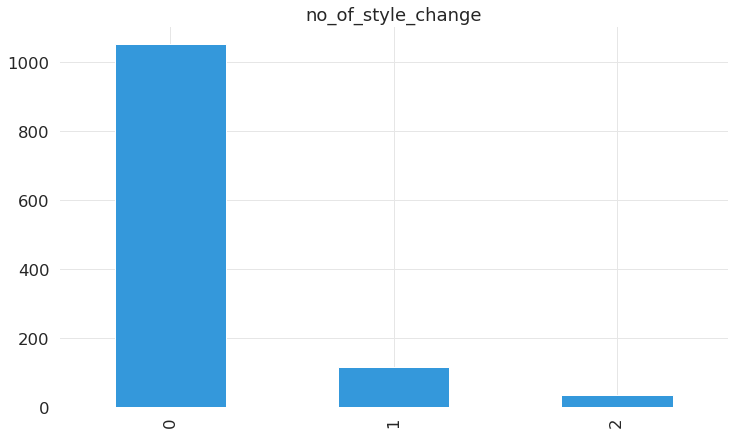

In [10]:
categorical_in_disguise = ['team', 'no_of_style_change']

for i in range(len(categorical_in_disguise)):
    df[categorical_in_disguise[i]].value_counts().plot(kind='bar', title=categorical_in_disguise[i])
    plt.savefig(GRAPHICS_LOCATION + 'EDA_Categorical_In_disguise_Distribution_' + categorical_in_disguise[i] + '.png')
    plt.show()

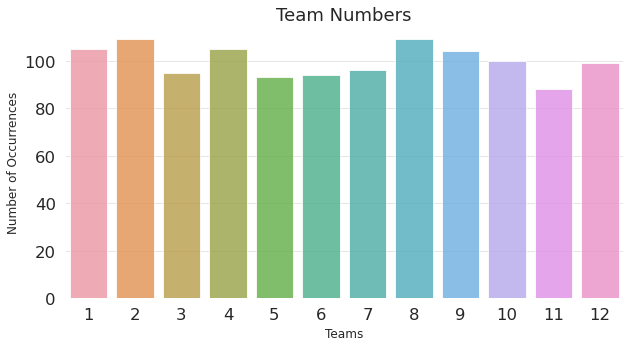

In [11]:
# Team feature is a categorical variable
team_count = df.team.value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = team_count.index, y = team_count.values, alpha=0.8)
plt.title('Team Numbers')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Teams', fontsize=12)
plt.savefig(GRAPHICS_LOCATION + 'EDA_Categorical_In_disguise_Teams.png')
plt.show()

**Intermediary Conclusion:** Bllaaaaerb

### Nullity of columns
Let's start by seeing how our nulls are distributed

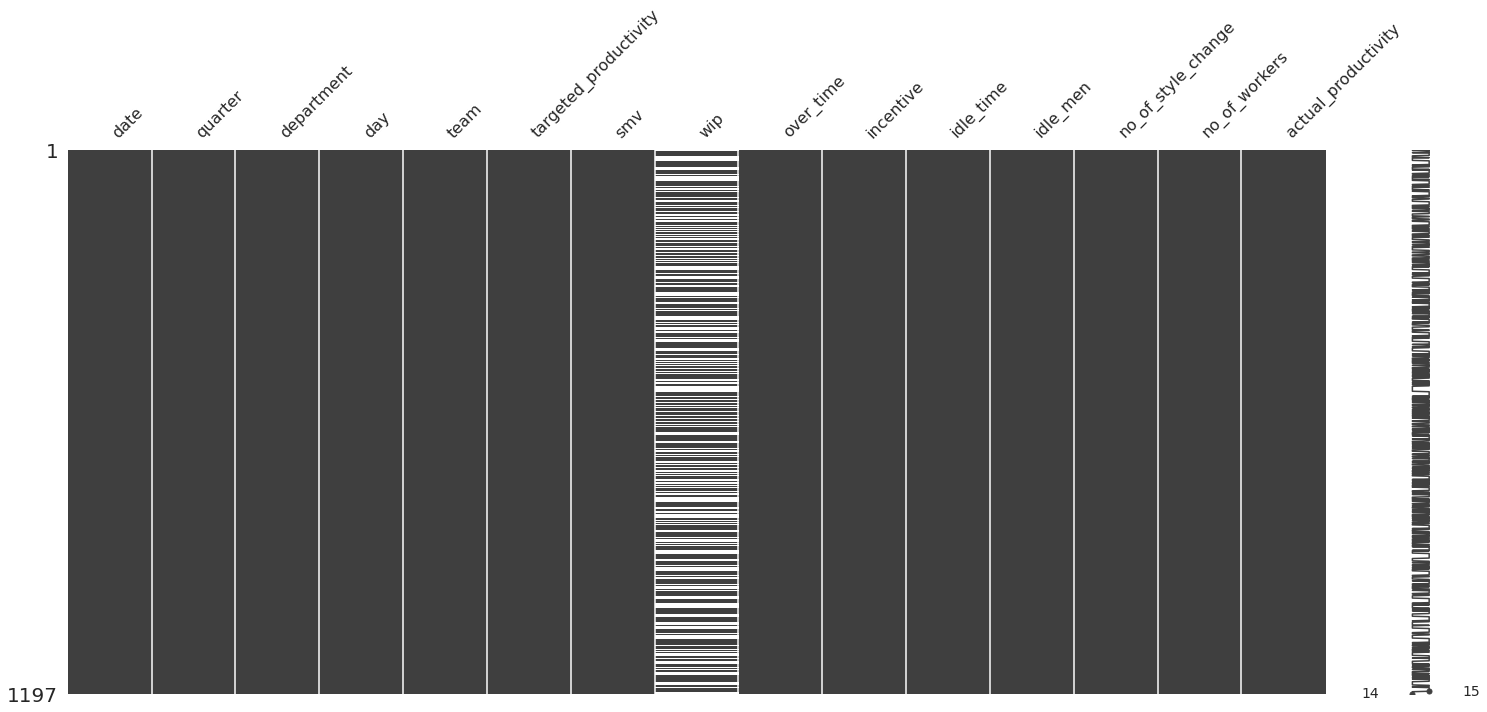

In [12]:
#msno.bar(df)
#plt.show()

msno.matrix(df)
plt.savefig(GRAPHICS_LOCATION + 'EDA_null_matrix.png')
plt.show()

#msno.heatmap(df)
#plt.show()

**Intermediary Conclusion:** It seems to only be the column `wip` _(Work in progress. Includes the number of unfinished items for products)_ that contains nulls, and they seem to be **Missing At Random**

### Correlation between target and actual
Let's see how the targeted productivity corresponds to the actual productivity

#### Distribution differences

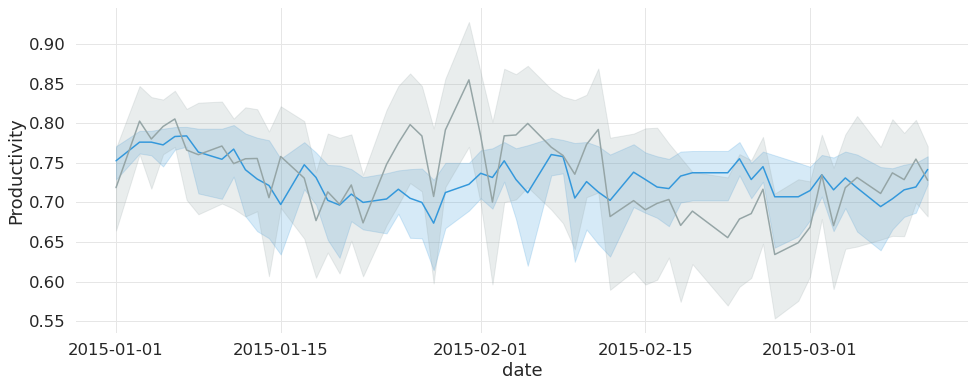

In [13]:
plt.figure(figsize = (16,6))
ax=sns.lineplot(y='targeted_productivity',x='date' ,data = df, legend='brief')
ax=sns.lineplot(y= 'actual_productivity',x='date',data=df, legend = 'brief')
ax.set(ylabel = 'Productivity')
plt.savefig(GRAPHICS_LOCATION + 'EDA_target_vs_actual_TimeSeries.png')
plt.show()

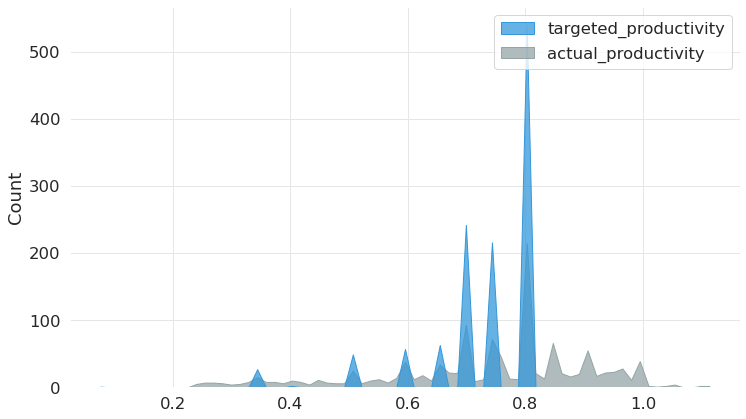

In [14]:
sns.histplot(data=df[['targeted_productivity', 'actual_productivity']], element='poly')
plt.savefig(GRAPHICS_LOCATION + 'EDA_target_vs_actual.png')
plt.show()

**Intermediary Conclusion:** Don't know yet... Most of the time, target seems higher than actual

#### Correlations to the actual productivity
Let's see what affects the actual productivity

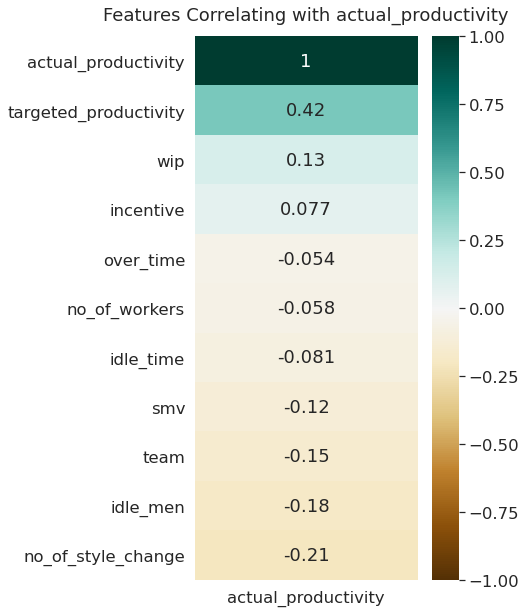

In [15]:
corrMatrix = df.corr()
plt.figure(figsize=(5, 10))
heatmap = sns.heatmap(corrMatrix[['actual_productivity']].sort_values(by='actual_productivity', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with actual_productivity', fontdict={'fontsize':18}, pad=16);
plt.savefig(GRAPHICS_LOCATION + 'EDA_Attribute_Correlation_With_Actual.png')
plt.show()

**Intermediary Conclusion:** Target seems to be a decent indicator, meaning that workers do speed up when target is high. we also see that the number of style change request negatively effects it...
    

### Pairwise Correlations

#### Looking at them visually

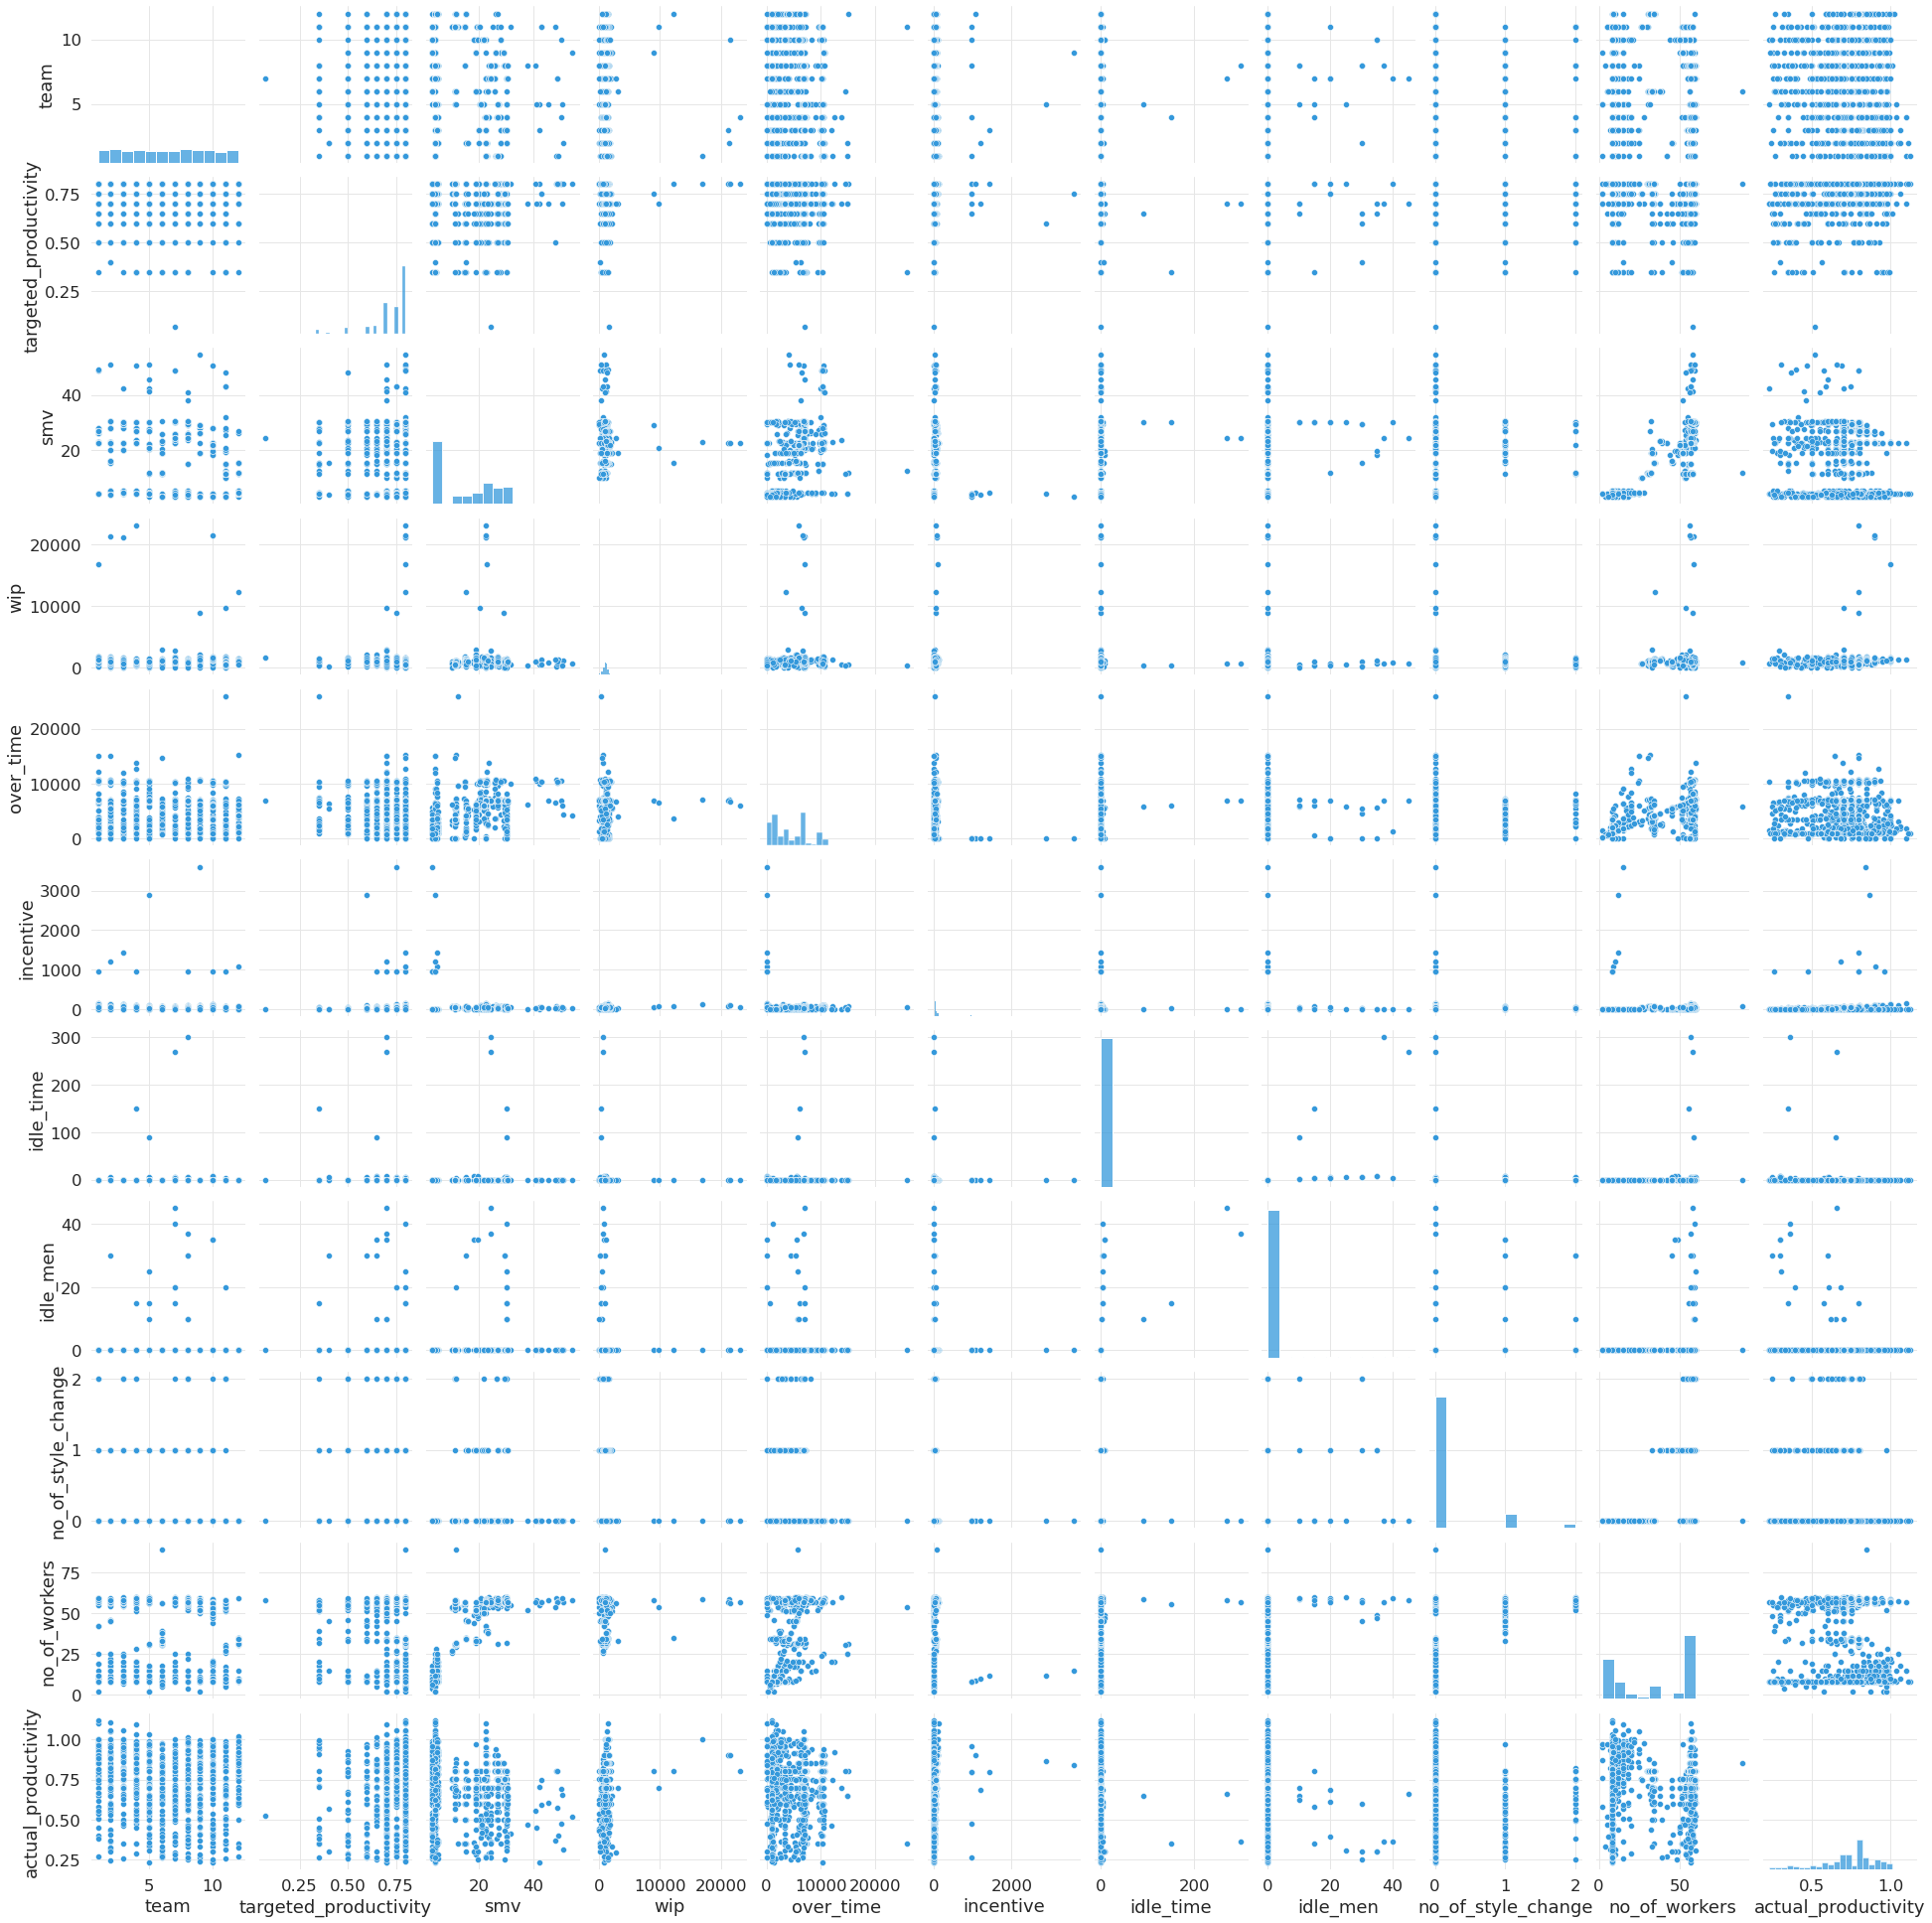

In [16]:
sns.pairplot(df)
plt.savefig(GRAPHICS_LOCATION + 'EDA_Pairwise_Correlation_Matrix.png')
plt.show()

**Intermediary Conclusion:** Oookay These are too many columns to visualize. However, it is easy to see that e.g. Quarter, date, and day all represent partially the same, and could be excluded. Probably other data could as well... Lets get back to that later

#### List of important correlations
As the above was a bit unreadable, let's try to create a list of most correlated attributes

##### Pearson
_from: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/_
The Pearson correlation evaluates the linear relationship between two continuous variables. A relationship is linear when a change in one variable is associated with a proportional change  in the other variable.

For example, you might use a Pearson correlation to evaluate whether increases in temperature at your production facility are associated with decreasing thickness of your chocolate coating.

##### Kendall
_from https://www.statsdirect.com/help/nonparametric_methods/kendall_correlation.htm_
Kendall's rank correlation provides a distribution free test of independence and a measure of the strength of dependence between two variables.

Spearman's rank correlation is satisfactory for testing a null hypothesis of independence between two variables but it is difficult to interpret when the null hypothesis is rejected.  Kendall's rank correlation improves upon this by reflecting the strength of the dependence between the variables being compared.

##### Spearman
_from: https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/_
The Spearman correlation evaluates the monotonic relationship between two continuous or ordinal variables. In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data.

Spearman correlation is often used to evaluate relationships involving ordinal variables. For example, you might use a Spearman correlation to evaluate whether the order in which employees complete a test exercise is related to the number of months they have been employed.

In [17]:
# Create functions for calculating
## Inspired/stolen from https://stackoverflow.com/questions/54207492/creating-a-list-from-a-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, correlation_type = 'spearman', abs_only = False, n=500):
    df_corr = df.corr(method=correlation_type)
    #display(df_corr.style.background_gradient(cmap="Blues"))
    au_corr = df_corr
    if abs_only:
        au_corr = au_corr.abs()
    au_corr = au_corr.unstack()
    labels_to_drop = get_redundant_pairs(df_corr)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    #print("Top Absolute Correlations")
    #print(au_corr[0:n])
    return au_corr[0:n]

def compare_correlations(df):
    corr_spearman = get_top_abs_correlations(df, correlation_type = 'spearman', abs_only = False, n=30)
    corr_pearson = get_top_abs_correlations(df, correlation_type = 'pearson', abs_only = False, n=30)
    corr_kendall = get_top_abs_correlations(df, correlation_type = 'kendall', abs_only = False, n=30)
    
    corr_spearman = pd.DataFrame(corr_spearman, columns=['spearman'])
    corr_pearson = pd.DataFrame(corr_pearson, columns=['pearson'])
    corr_kendall = pd.DataFrame(corr_kendall, columns=['kendall'])
    
    returned_df = corr_spearman.join(corr_pearson)
    returned_df = returned_df.join(corr_kendall)
    
    display(returned_df.style.background_gradient(cmap="Blues"))
    
    return returned_df

rdf = compare_correlations(df)

,,spearman,pearson,kendall
idle_time,idle_men,0.999964,0.559146,0.996560
smv,no_of_workers,0.890726,0.912176,0.736938
over_time,no_of_workers,0.744135,0.734164,0.620334
smv,over_time,0.699636,0.674887,0.530922
incentive,no_of_workers,0.657264,0.049222,0.513167
smv,incentive,0.600507,0.032629,0.446730
over_time,incentive,0.538956,-0.004793,0.416780
targeted_productivity,actual_productivity,0.448375,0.421594,0.361793
smv,no_of_style_change,0.382278,0.315388,0.314877
no_of_style_change,no_of_workers,0.338092,0.327787,0.283731


**Intermediary Conclusion:** Irregardless of which method we choose, there seems to be quite a good structure to which columns are correlated.

### Understand the difference between Actual and target
One way to visualize this, is to calculate the difference between these values, and visually inspect when it changes

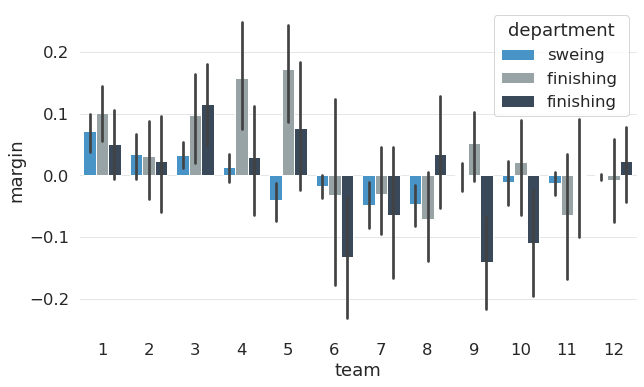

In [18]:
# Add margin
df['margin'] = df['actual_productivity'] - df['targeted_productivity']

# Show plot
f, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=df, x='team', y='margin', hue='department', ax=ax)
plt.savefig(GRAPHICS_LOCATION + 'EDA_Difference_in_margin.png')
plt.show()

# Delete again
df.drop(columns = 'margin',inplace = True)

**Intermediary Conclusion:** Blæaarb

## Preprocessing
Next step is preparing for modelling

### Data Cleansing
Fixing the various faults found earlier

#### Department
This column contains a erroneous space, as well as a typo

In [19]:
# Original values:
print(df.department.unique())

# Cleanse
## Remove space
df['department'] = df.department.str.strip()
## Replace typo
df['department'] = df.department.replace(['sweing'],['sewing'])

# Check values again:
print(df.department.unique())

['sweing' 'finishing ' 'finishing']
['sewing' 'finishing']


#### Fix `WIP` missing values
As it seems to be Missing At Random, we are interpolating by time

In [20]:
df['wip'].interpolate(method='time', inplace=True)

### Feature Engineering
Next up is creating some missing features, and or re-encoding

#### Add Month Column

In [21]:
df['month'] = df['date'].dt.month_name() 

#### Modify Incentive
Add a tiny amount for better modelling

In [22]:
df.loc[df.incentive==0, 'incentive'] = 0.0001

#### Man power per smv

In [23]:
df['smv_manpower'] = np.log(df['smv'] / df['no_of_workers'])

#### One-hot enconding
Change to strings, to we get use pandas `get_dummies`

In [24]:
# Change to string
df['team']=df['team'].astype(str)
df['no_of_style_change']=df['no_of_style_change'].astype(str)
# One-hot-encode
df=pd.get_dummies(df)
# Drop date
df.drop(columns = 'date',inplace = True)

#### Scaling

In [25]:
min_max_scaler = MinMaxScaler()
cols  = ['smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_workers']

df[cols] = min_max_scaler.fit_transform(df[cols])

### Train/Test/Val Split
Split into X and Y, and then into Train/test - and from train to train/val

In [26]:
X, y = df.drop(['actual_productivity'], axis=1), df['actual_productivity']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Shapes:')
print(f"Train: x={X_train.shape}, y={y_train.shape}")
print(f"Test: x={X_test.shape}, y={y_test.shape}")
print(f"Validation: x={X_val.shape}, y={y_val.shape}")

Shapes:
Train: x=(717, 40), y=(717,)
Test: x=(240, 40), y=(240,)
Validation: x=(240, 40), y=(240,)


## Build models

### Setup of evaluation

In [28]:
# Store results
performance_Results = pd.DataFrame(columns = ['models','mae','mse', 'rmse' ,'mape', 'R2'])

# Test models
def evaluate_model(model_name, Y_actual, Y_Predicted, df):
    # Calculate metrics
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    mae = metrics.mean_absolute_error(Y_actual, Y_Predicted)
    mse = metrics.mean_squared_error(Y_actual, Y_Predicted)
    rmse = np.sqrt(metrics.mean_squared_error(Y_actual, Y_Predicted))
    r2 = metrics.r2_score(Y_actual, Y_Predicted)
    
    # Concatenate
    df_temp = {'models':model_name,'mae':mae,'mse':mse, 'rmse':rmse, 'mape':mape, 'R2': r2}
    df = df.append(df_temp, ignore_index = True)
    
    # Visualize
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    plt.xlabel("Actual Productivity")
    plt.ylabel("Predicted Productivity")
    plt.title(f"Actual vs Predicted for {model_name} Model")
    plt.savefig(GRAPHICS_LOCATION + 'Results_Actual_Vs_Predicted_Model_' + model_name.replace(" ", "_") + '.png')
    plt.show()
    
    # Show metrics
    print(f"MAPE:{mape}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE:{rmse}")
    print(f"R2:  {r2}")
    print("------------------------")
    
    # End
    return df

### Linear Regression

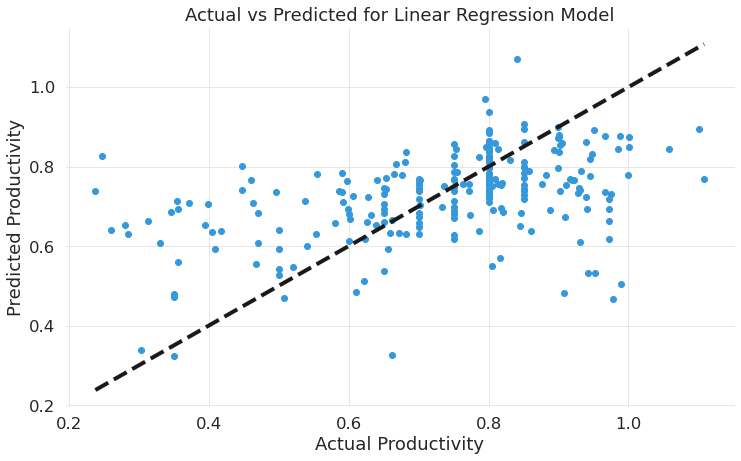

MAPE:20.396601379474564
MAE: 0.12001649843942058
MSE: 0.02656542768458575
RMSE:0.1629890416088939
R2:  0.17060257716910399
------------------------


In [29]:
# Build Model
model = LinearRegression()
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('Linear Regression', y_test, y_pred, performance_Results)

### Lasso Regression

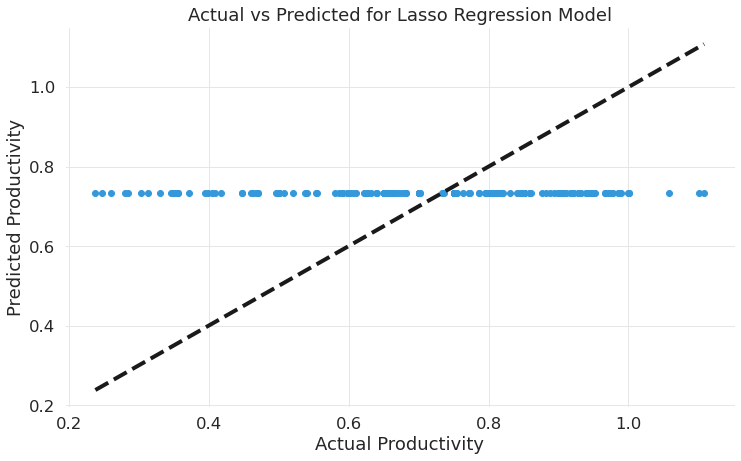

MAPE:25.08114603708474
MAE: 0.1412337298208101
MSE: 0.032030126339049426
RMSE:0.17896962406802286
R2:  -1.0410296161333932e-05
------------------------


In [30]:
# Build Model
model = Lasso()
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('Lasso Regression', y_test, y_pred, performance_Results)

### Ridge Regression

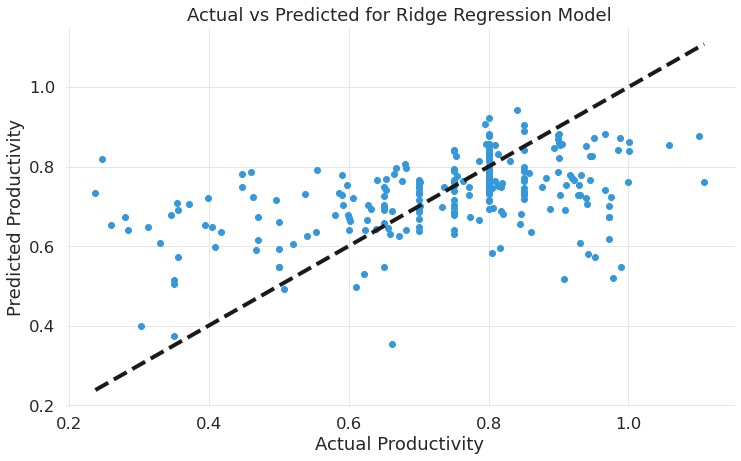

MAPE:20.375905120629177
MAE: 0.11867515377606846
MSE: 0.02562268141986698
RMSE:0.16007086374436474
R2:  0.2000359946026541
------------------------


In [31]:
# Build Model
model = Ridge()
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('Ridge Regression', y_test, y_pred, performance_Results)

#### Random Forrest

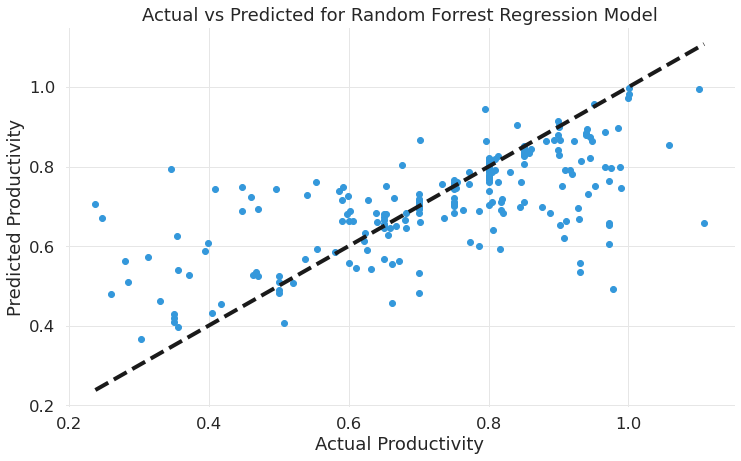

MAPE:14.532157358209128
MAE: 0.08529605571737502
MSE: 0.0178652002462577
RMSE:0.13366076554568174
R2:  0.4422317901848949
------------------------


In [32]:
# Build Model
model = RandomForestRegressor(n_estimators = 100 ,  random_state = 10)
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('Random Forrest Regression', y_test, y_pred, performance_Results)

#### Support Vector Regression

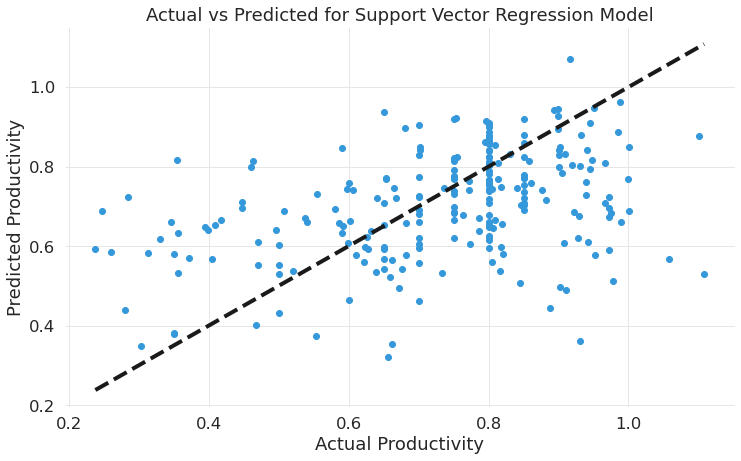

MAPE:21.584930139250456
MAE: 0.1352784245071233
MSE: 0.03170878486112342
RMSE:0.17806960678656933
R2:  0.010022170274530895
------------------------


In [33]:
# Build Model
model = SVR(C=25)
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('Support Vector Regression', y_test, y_pred, performance_Results)

#### K Nearest Neighbours

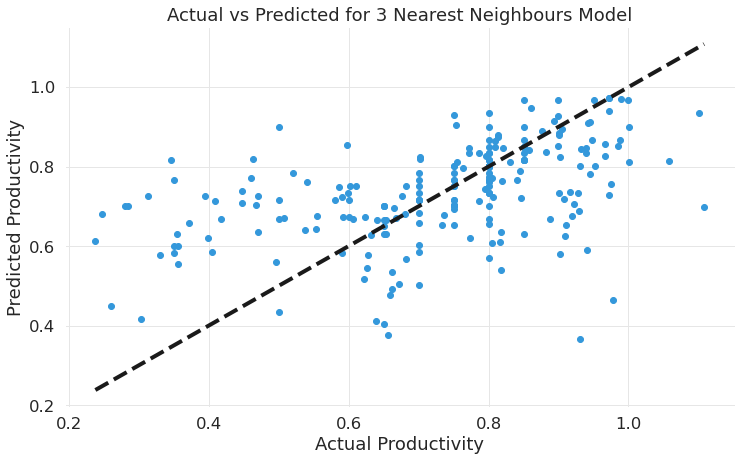

MAPE:20.259281198557215
MAE: 0.11370972188194445
MSE: 0.02587153521054677
RMSE:0.16084630928481625
R2:  0.19226654721780068
------------------------


In [34]:
# Build Model
model = KNeighborsRegressor(n_neighbors=3)
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('3 Nearest Neighbours', y_test, y_pred, performance_Results)

#### Extreme Gradient Descent Boosting

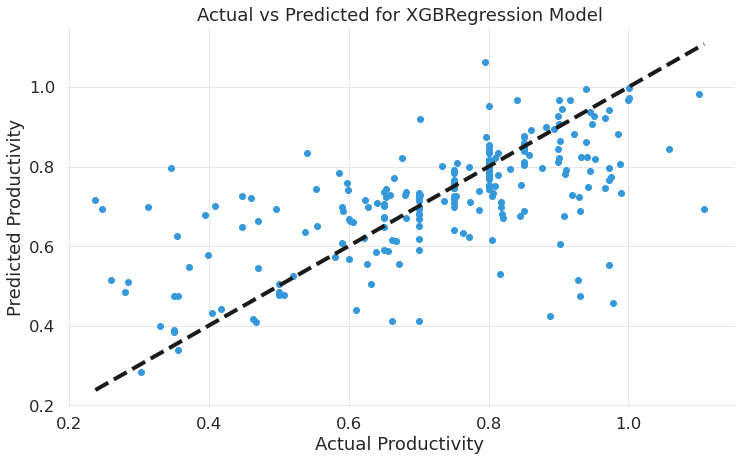

MAPE:15.459565926513664
MAE: 0.09204421878612862
MSE: 0.019676034278372456
RMSE:0.14027128814683515
R2:  0.3856958632183617
------------------------


In [35]:
# Build Model
model = xgb.XGBRegressor(verbosity = 0)
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('XGBRegression', y_test, y_pred, performance_Results)

#### Gradient Boosting

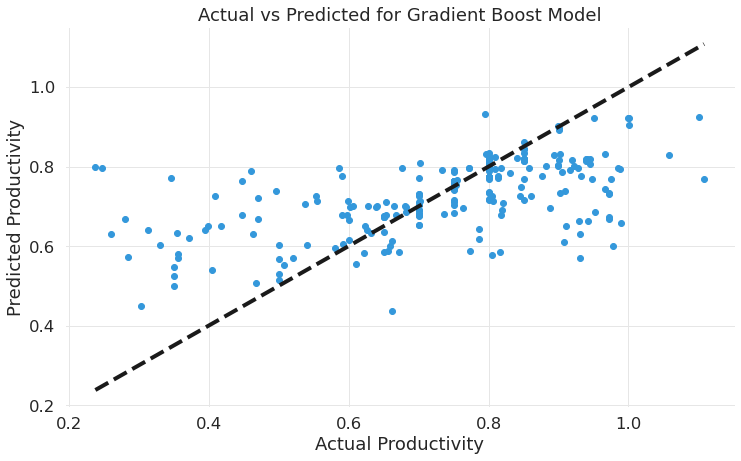

MAPE:17.89877213440616
MAE: 0.1003541882013773
MSE: 0.02140360992607185
RMSE:0.14629972633628488
R2:  0.33175934064625634
------------------------


In [36]:
# Build Model
model = GradientBoostingRegressor(alpha=0.9,learning_rate=0.05, max_depth=2, min_samples_leaf=5, min_samples_split=2, n_estimators=100, random_state=30)
# Fit Model
model.fit(X_train,y_train)
# Predict on test set
y_pred = model.predict(X_test)
# Evaluate model
performance_Results = evaluate_model('Gradient Boost', y_test, y_pred, performance_Results)

### Compare models

In [37]:
def create_barplot(metric):
    plt.figure(figsize=(10, 5))
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(data=performance_Results
                     , x="models"
                     , y=metric).set_title(str.upper(metric) + ' comparisson between models')
    plt.xticks(rotation=90)
    plt.savefig(GRAPHICS_LOCATION + 'Results_Model_Comparisson_' + str.upper(metric) + '.png')
    plt.show()

#### Table with comparisson of models

In [38]:
performance_Results.style.background_gradient(axis=0)

,models,mae,mse,rmse,mape,R2
0,Linear Regression,0.120016,0.026565,0.162989,20.396601,0.170603
1,Lasso Regression,0.141234,0.032030,0.178970,25.081146,-0.000010
2,Ridge Regression,0.118675,0.025623,0.160071,20.375905,0.200036
3,Random Forrest Regression,0.085296,0.017865,0.133661,14.532157,0.442232
4,Support Vector Regression,0.135278,0.031709,0.178070,21.584930,0.010022
5,3 Nearest Neighbours,0.113710,0.025872,0.160846,20.259281,0.192267
6,XGBRegression,0.092044,0.019676,0.140271,15.459566,0.385696
7,Gradient Boost,0.100354,0.021404,0.146300,17.898772,0.331759


#### MAE 

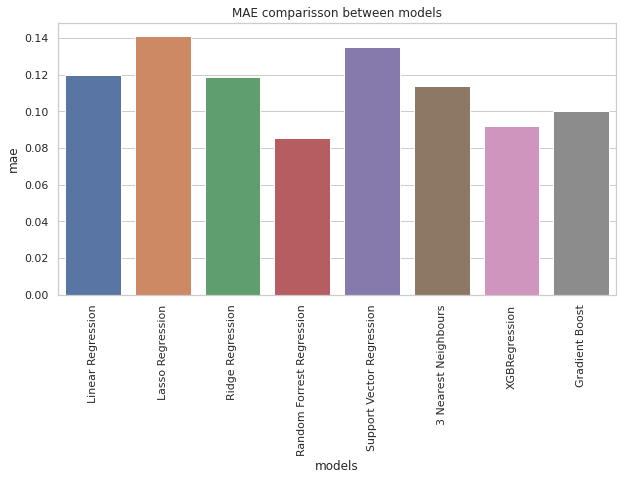

In [39]:
create_barplot('mae')

#### MSE

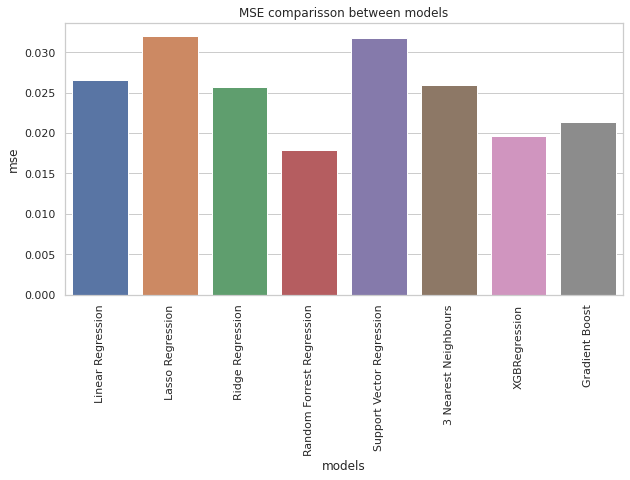

In [40]:
create_barplot('mse')

#### RMSE

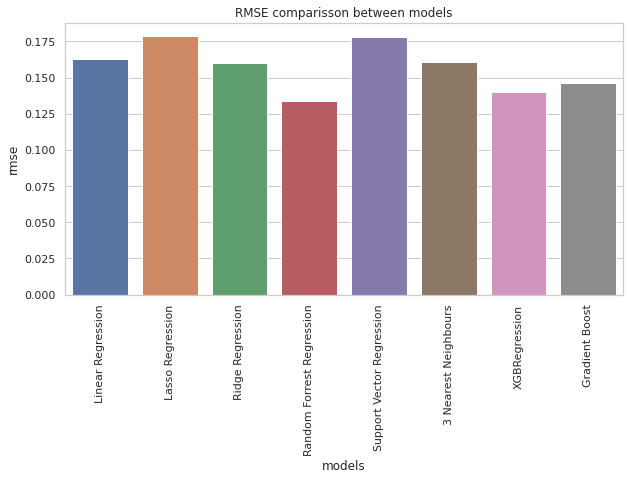

In [41]:
create_barplot('rmse')

#### MAPE

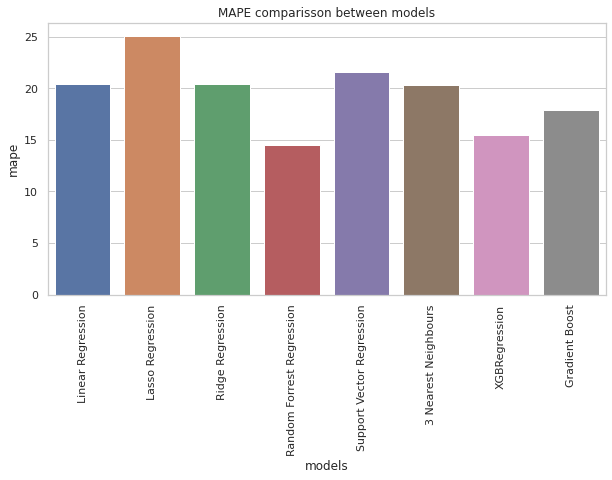

In [42]:
create_barplot('mape')

#### R2

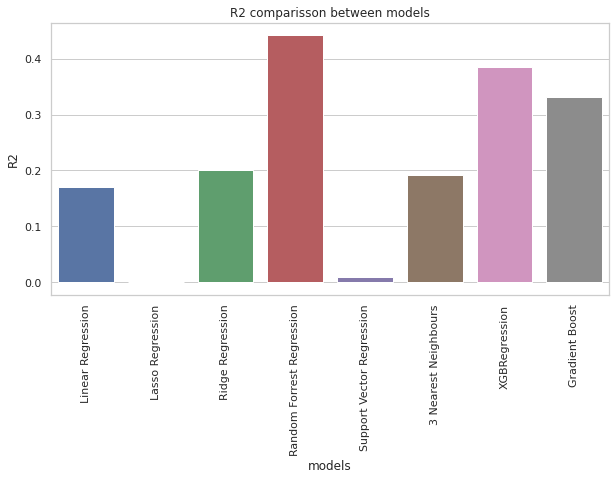

In [43]:
create_barplot('R2')